In [3]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np

# Tensorflow Stuff
import tensorflow.keras.initializers
import statistics
import tensorflow.keras as keras
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, InputLayer
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import ShuffleSplit
from tensorflow.keras.layers import ReLU
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [21]:
energies = np.linspace(1, 20000, 400)
for energy in energies:
    print("neutron" , energy, "keV 1000000")

neutron 1.0 keV 1000000
neutron 51.12280701754386 keV 1000000
neutron 101.24561403508773 keV 1000000
neutron 151.3684210526316 keV 1000000
neutron 201.49122807017545 keV 1000000
neutron 251.61403508771932 keV 1000000
neutron 301.7368421052632 keV 1000000
neutron 351.859649122807 keV 1000000
neutron 401.9824561403509 keV 1000000
neutron 452.1052631578948 keV 1000000
neutron 502.22807017543863 keV 1000000
neutron 552.3508771929825 keV 1000000
neutron 602.4736842105264 keV 1000000
neutron 652.5964912280702 keV 1000000
neutron 702.719298245614 keV 1000000
neutron 752.8421052631579 keV 1000000
neutron 802.9649122807018 keV 1000000
neutron 853.0877192982457 keV 1000000
neutron 903.2105263157896 keV 1000000
neutron 953.3333333333334 keV 1000000
neutron 1003.4561403508773 keV 1000000
neutron 1053.578947368421 keV 1000000
neutron 1103.701754385965 keV 1000000
neutron 1153.8245614035088 keV 1000000
neutron 1203.9473684210527 keV 1000000
neutron 1254.0701754385966 keV 1000000
neutron 1304.1929824

In [77]:
with open('keVtoLightYield.pickle', 'rb') as handle:
    data = pickle.load(handle)

In [78]:
# Takes index from 
indexToKey = [key for key in data.keys() if key not in "bins"]
indexToKey.sort()
indexToKey = np.array(indexToKey)
    
# Gets the dimensions of the x and y data
xDim = len(data[indexToKey[0]])
yDim = len(indexToKey)

def loadRandomGaussianData(data, num):

    # Normalizes the data
    def normalize(counts):
        bins = data["bins"]
        binWidth = bins[1] - bins[0]
        counts = counts / ( binWidth * sum(counts) )
        return counts

    # Randomly adds a gaussian peak to a 1D array
    def addGaussian(data, i):
        # Randomly picks the width and height of the gaussian
        # ~8 is placeholder for typical width of peak in the real-world data (depends on detector resolution)
        H = np.random.normal(loc = 20.0, scale = 10.0)
        W = int( np.abs(np.random.normal(loc = 30.0, scale = 15.0 / (np.abs(H) + 0.01) ))) + 1

        for k in range(-W, W + 1):
            if (i + k) >= len(data):
                break
            elif (i + k) < 0:
                continue
            else:
                data[i + k] += H * np.exp(- (2.5*k/W)**2)
                
    # Gets the detector response of a given neutron spectra
    def getX(yRow):
        xRow = np.zeros(xDim)
        for index in range(yDim):
            xRow += yRow[index] * data[indexToKey[index]]
            
        return normalize(xRow)
          
    x = np.zeros( (0, xDim) )
    y = np.zeros( (0, yDim) )
    #14045
    for _ in range(2000):
        yRow = np.zeros(len(indexToKey))

        i = np.random.randint(low = 0, high = yDim + 1)
        addGaussian(yRow, i)
        
        # Flip a coin and keep adding gaussian spikes
        p = np.random.random()
        while p > 0.2:
            i = np.random.randint(low = 0, high = yDim + 1)
            addGaussian(yRow, i)
            p = np.random.random()
                
        yRow = np.abs(yRow)
        yRow = yRow / sum(yRow)
        xRow = getX(yRow)

        x = np.vstack( (x, xRow) )
        y = np.vstack( (y, yRow) )    

    return x,y

In [8]:
# Gets x and y dimension of the data 
indexToKey = [key for key in data.keys() if key not in "bins"]
indexToKey.sort()
indexToKey = np.array(indexToKey)

xDim = len(data[indexToKey[0]])
yDim = len(indexToKey)
    
def bootstrapModel(numNeurons0, numNeurons1, numNeurons2, alpha0, alpha1, alpha2, dropout):
    
    error = []
    
    for _ in range(1):
        model = getModel(xDim, yDim, numNeurons0, numNeurons1, numNeurons2, alpha0, alpha1, alpha2, dropout)
        model.compile(loss = "categorical_crossentropy", optimizer = Adam() )

        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-7, 
                                patience=1, verbose=0,
                                mode='min', restore_best_weights=True)

        x,y = loadRandomGaussianData(data, 400)
        
        model.fit(x, y, validation_split = 0.05, batch_size = 60, callbacks=[monitor], verbose=0, epochs=10000)

        xtest, ytest = loadRandomGaussianData(data, 100)
        ypred = model( xtest )
        error.append( metrics.mean_squared_error(ytest, ypred) )
        
    print( "Error : " , np.mean(error), " ± ", np.std(error) )
    return - np.mean( error )

def getModel(xDim, yDim, numNeurons0, numNeurons1, numNeurons2, alpha0, alpha1, alpha2, dropout):
    
    numNeurons0 = int( numNeurons0 )
    numNeurons1 = int( numNeurons1 )
    numNeurons2 = int( numNeurons2 )
    
    model = keras.Sequential()
    model.add(keras.Input(xDim))
    if numNeurons0 >= 1:
        model.add(Dropout(dropout))
        model.add(Dense(numNeurons0, activation=keras.layers.LeakyReLU(alpha = alpha0)))
    if numNeurons1 >= 1:
        model.add(Dropout(dropout))
        model.add(Dense(numNeurons1, activation=keras.layers.LeakyReLU(alpha = alpha1)))
    if numNeurons2 >= 1:
        model.add(Dropout(dropout))
        model.add(Dense(numNeurons2, activation=keras.layers.LeakyReLU(alpha = alpha2)))
        
    model.add(Dense(yDim, activation = 'softmax'))
    return model
    
    

In [9]:
pbounds = {'numNeurons0' : (200,600),
           'numNeurons1' : (200,600), 
           'numNeurons2' : (200,600), 
           'alpha0' : (0, 0.9), 
           'alpha1' : (0, 0.9), 
           'alpha2' : (0, 0.9), 
           'dropout': (0, 0.2)
           }
optimizer = BayesianOptimization(
    f=bootstrapModel,
    pbounds=pbounds,
    verbose=2,
    random_state=1
)

optimizer.maximize(init_points=150, n_iter=50)

print("Best Value : " , optimizer.max)
Best = optimizer.max

|   iter    |  target   |  alpha0   |  alpha1   |  alpha2   |  dropout  | numNeu... | numNeu... | numNeu... |
-------------------------------------------------------------------------------------------------------------
Error :  1.00463864181284e-05  ±  0.0
|  1        | -1.005e-0 |  0.3753   |  0.6483   |  0.000102 |  0.06047  |  258.7    |  236.9    |  274.5    |
Error :  1.1818209038885991e-05  ±  0.0
|  2        | -1.182e-0 |  0.311    |  0.3571   |  0.4849   |  0.08384  |  474.1    |  281.8    |  551.2    |
Error :  1.757642081863727e-05  ±  0.0
|  3        | -1.758e-0 |  0.02465  |  0.6034   |  0.3756   |  0.1117   |  256.2    |  279.2    |  520.3    |
Error :  1.1621810384683296e-05  ±  0.0
|  4        | -1.162e-0 |  0.8714   |  0.2821   |  0.6231   |  0.1753   |  557.8    |  234.0    |  215.6    |
Error :  1.440679174971738e-05  ±  0.0
|  5        | -1.441e-0 |  0.1528   |  0.7903   |  0.08851  |  0.08422  |  583.2    |  413.3    |  476.8    |
Error :  9.545510488488222e-06  ± 

KeyboardInterrupt: 

In [33]:
Best = {'target': -0.0002807046020602577, 
        'params': {
            'numNeurons0': 532.5106601410772, 
            'numNeurons1': 341.60973480326476, 
            'numNeurons2': 439.0057187408672,
            'dropout'    : 0.01841923339536132,
            'alpha0': 0.13, 
            'alpha1': 0.23,
            'alpha2': 0.27
             }}

alpha0 = Best['params']['alpha0']
alpha1 = Best['params']['alpha1']
alpha2 = Best['params']['alpha2']
dropout = Best['params']['dropout']
numNeurons0 = Best['params']['numNeurons0']
numNeurons1 = Best['params']['numNeurons1']
numNeurons2 = Best['params']['numNeurons2']

indexToKey = [key for key in data.keys() if key not in "bins"]
indexToKey.sort()
indexToKey = np.array(indexToKey)

xDim = len(data[indexToKey[0]])
yDim = len(indexToKey)

model = getModel(xDim, yDim, numNeurons0, numNeurons1, numNeurons2, alpha0, alpha1, alpha2, dropout)

model.compile(loss = "categorical_crossentropy", optimizer = Adam() )

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-8, 
                        patience=10, verbose=0,
                        mode='min', restore_best_weights=True)

x,y = loadRandomGaussianData(data, 10000)
        
model.fit(x, y, validation_split=0.1, batch_size = 120, callbacks=[monitor], verbose=0, epochs=10000)

In [21]:
meanErr = []
for _ in range(20):
    xtest, ytest = loadRandomGaussianData(data, 300)
    error = metrics.mean_squared_error(ytest, model(xtest))
    meanErr.append(error)
    
print(np.mean(meanErr), " ± ", np.std(meanErr))

8.54613737279207e-05  ±  1.5596171019401064e-06


In [34]:
# (0, 4) and 100 Bins -> 0.000144 ± 1.57e-5
# (0, 4) and 50 Bins -> 0.000182 ± 1.5e-5
# (0, 1) and 100 Bins -> 0.000112 ± 2e-5
# (0, 0.5) and 100 Bins -> 0.000093 ± 3.6e-5
# (0, 0.5) and 50 Bins -> 0.000124 ± 2.8e-5
# (0, 0.5) and 200 Bins -> 5.433e-05 ± 9.5e-06

In [12]:
xtest, ytest = loadRandomGaussianData(data, 20)

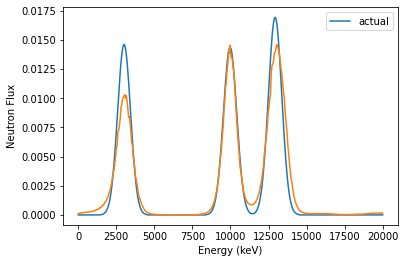

In [63]:
i = 5
plt.plot(np.linspace(1, 20000, 400), ytest[i], label = "actual")
plt.plot(np.linspace(1, 20000, 400), model(xtest)[i])
plt.xlabel("Energy (keV)")
plt.ylabel("Neutron Flux")
plt.legend()

(0.31446540880503143, 30.0)

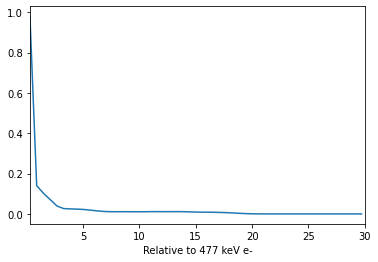

In [24]:
plt.plot(data["bins"], xtest[2])
plt.xlabel("Relative to 477 keV e-")
plt.xlim(150 / 477, 30)

In [26]:
150 / 477

0.31446540880503143

In [25]:
data["bins"]

array([ 0.30099,  0.90097,  1.50095,  2.10093,  2.70091,  3.30089,
        3.90087,  4.50085,  5.10083,  5.70081,  6.30079,  6.90077,
        7.50075,  8.10073,  8.70071,  9.30069,  9.90067, 10.50065,
       11.10063, 11.70061, 12.30059, 12.90057, 13.50055, 14.10053,
       14.70051, 15.30049, 15.90047, 16.50045, 17.10043, 17.70041,
       18.30039, 18.90037, 19.50035, 20.10033, 20.70031, 21.30029,
       21.90027, 22.50025, 23.10023, 23.70021, 24.30019, 24.90017,
       25.50015, 26.10013, 26.70011, 27.30009, 27.90007, 28.50005,
       29.10003, 29.70001])

Text(0.5, 0, 'keVee')

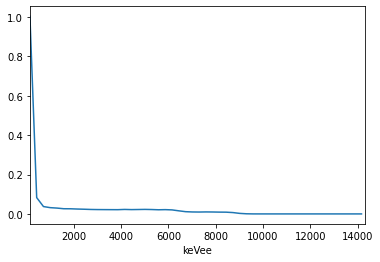

In [22]:
plt.plot(477 * data["bins"], xtest[-2])
plt.xlim(150, 30 * 477)
plt.xlabel("keVee")

In [48]:
len(data.keys())

401

In [14]:
data["bins"]

array([ 0.30099,  0.90097,  1.50095,  2.10093,  2.70091,  3.30089,
        3.90087,  4.50085,  5.10083,  5.70081,  6.30079,  6.90077,
        7.50075,  8.10073,  8.70071,  9.30069,  9.90067, 10.50065,
       11.10063, 11.70061, 12.30059, 12.90057, 13.50055, 14.10053,
       14.70051, 15.30049, 15.90047, 16.50045, 17.10043, 17.70041,
       18.30039, 18.90037, 19.50035, 20.10033, 20.70031, 21.30029,
       21.90027, 22.50025, 23.10023, 23.70021, 24.30019, 24.90017,
       25.50015, 26.10013, 26.70011, 27.30009, 27.90007, 28.50005,
       29.10003, 29.70001])